In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from timeit import default_timer as timer
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import seaborn as sn
import pandas as pd

from prettytable import PrettyTable

In [ ]:
from google.colab import drive
import os

In [ ]:
#/content/drive/MyDrive/TCC/partition/partition-1

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print  ("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (299,299)
NUM_CLASSES = 24
INPUT_SHAPE = (299,299,3)
OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model =Effnet(INPUT_SHAPE, NUM_CLASSES)

  # compilando o modelo

model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 32)      96        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 299, 299, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 32)     128       
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 299, 299, 32)     96        
 Conv2D)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 299, 299, 32)      0     

# MobileNET

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 64
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria  /content/drive/MyDrive/TCC2/checkpoint
    modelo = 'mobileNet'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
      os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)


  # create a new model 
    model_mobile =tf.keras.applications.MobileNet(
        input_shape = INPUT_SHAPE,
        weights=None,
        classes=NUM_CLASSES,
        classifier_activation="softmax",

    )

  # compilando o modelo

    model_mobile.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_mobile.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    plt.close()
    
    ## Weighted Accuracy
    y_pred = model_mobile.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)
    
    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)




Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - 756s 50s/step - loss: 3.2654 - accuracy: 0.0519 - val_loss: 3.1768 - val_accuracy: 0.0469
Epoch 2/300
15/15 [==============================] - 302s 20s/step - loss: 3.1565 - accuracy: 0.0740 - val_loss: 3.1783 - val_accuracy: 0.0391
Epoch 3/300
15/15 [==============================] - 134s 9s/step - loss: 3.0871 - accuracy: 0.1111 - val_loss: 3.1768 - val_accuracy: 0.0469
Epoch 4/300
15/15 [==============================] - 63s 4s/step - loss: 3.0280 - accuracy: 0.1479 - val_loss: 3.1788 - val_accuracy: 0.0469
Epoch 5/300
15/15 [==============================] - 37s 2s/step - loss: 2.9130 - accuracy: 0.1760 - val_loss: 3.1954 - val_accuracy: 0.0469
Epoch 6/300
15/15 [==============================] - 21s 1s/step - loss: 2.7723 - accuracy: 0.2094 - val_loss: 3.1982 - val_accuracy: 0.0312
Epoch 7/300
15/15 [===

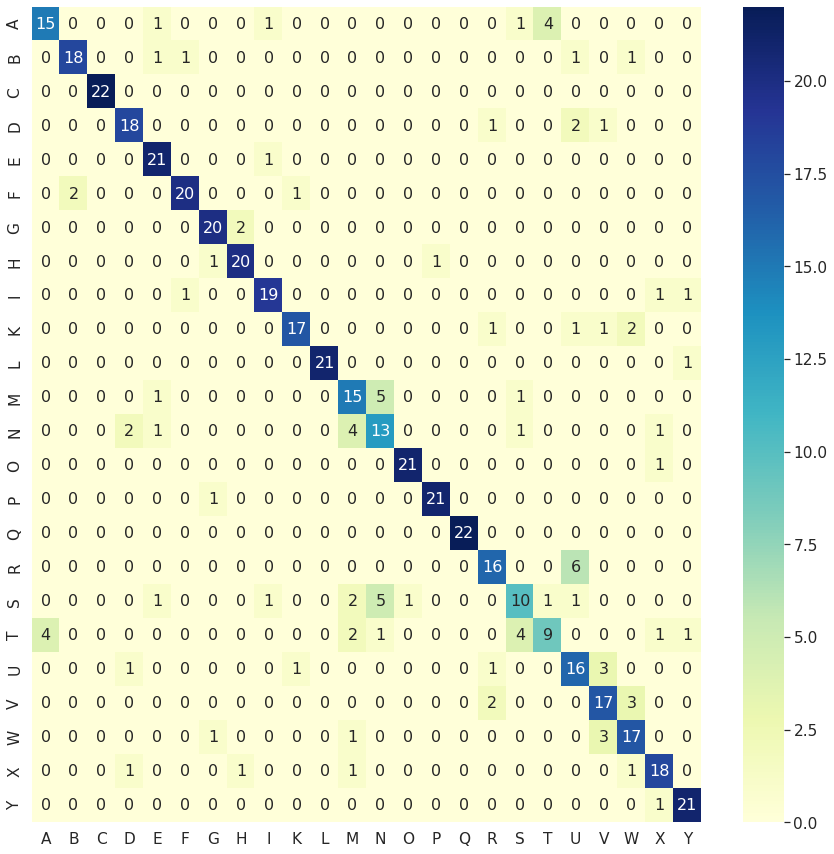

In [ ]:
classes = list(train_generator.class_indices.keys())

df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
plt.show()


#MobileV2

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 64
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria  /content/drive/MyDrive/TCC2/checkpoint
    modelo = 'mobileNetV2'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
      os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)


  # create a new model 
    model_mobile =tf.keras.applications.MobileNetV2(
        input_shape = INPUT_SHAPE,
        weights=None,
        classes=NUM_CLASSES,
        classifier_activation="softmax",

    )

  # compilando o modelo

    model_mobile.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_mobile.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    plt.close()
    
    ## Weighted Accuracy
    y_pred = model_mobile.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)
    
    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)

    classes = list(train_generator.class_indices.keys())
    df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
    plt.figure(figsize=(15,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
    plt.savefig(logs_path + "mc.jpg")
    plt.close()




Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.2752 - accuracy: 0.0413 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 728s 47s/step - loss: 3.2752 - accuracy: 0.0413 - val_loss: 3.1780 - val_accuracy: 0.0391
Epoch 2/300
15/15 [==============================] - 323s 22s/step - loss: 3.1244 - accuracy: 0.0906 - val_loss: 3.1775 - val_accuracy: 0.0547
Epoch 3/300
15/15 [==============================] - 142s 10s/step - loss: 2.9419 - accuracy: 0.1635 - val_loss: 3.1797 - val_accuracy: 0.0312
Epoch 4/300
15/15 [==============================] - 63s 4s/step - loss: 2.7427 - accuracy: 0.2222 - val_loss: 3.1784 - val_accuracy: 0.0391
Epoch 5/300
15/15 [==============================] - 33s 2s/step - loss: 2.5370 - accuracy: 0.3206 - val_loss: 3.1779 - val_accuracy: 0.0391
Epoch 6/300
15/15 [==============================] - 19s 1s/step - loss: 2.3783 - accuracy: 0.3438 - val_loss: 3.1786 - val_accuracy: 0.0156
Epoch 7/300
15/15 [==============================] - 13s 895ms/step - loss: 2.1772 - accuracy: 0.4240 - val_loss: 3.1767 - val_accuracy: 0.0547
Epoch 8/300
15/1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.2376 - accuracy: 0.0521 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 559s 37s/step - loss: 3.2376 - accuracy: 0.0521 - val_loss: 3.1781 - val_accuracy: 0.0078
Epoch 2/300
15/15 [==============================] - 250s 17s/step - loss: 3.0747 - accuracy: 0.1063 - val_loss: 3.1777 - val_accuracy: 0.0625
Epoch 3/300
15/15 [==============================] - 96s 6s/step - loss: 2.9067 - accuracy: 0.1510 - val_loss: 3.1782 - val_accuracy: 0.0547
Epoch 4/300
15/15 [==============================] - 51s 4s/step - loss: 2.7022 - accuracy: 0.2500 - val_loss: 3.1766 - val_accuracy: 0.0391
Epoch 5/300
15/15 [==============================] - 27s 2s/step - loss: 2.5560 - accuracy: 0.3005 - val_loss: 3.1772 - val_accuracy: 0.0547
Epoch 6/300
15/15 [==============================] - 21s 1s/step - loss: 2.3137 - accuracy: 0.3854 - val_loss: 3.1776 - val_accuracy: 0.0469
Epoch 7/300
15/15 [==============================] - 13s 831ms/step - loss: 2.1158 - accuracy: 0.4307 - val_loss: 3.1769 - val_accuracy: 0.0312
Epoch 8/300
15/15 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.2639 - accuracy: 0.0360 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 544s 36s/step - loss: 3.2639 - accuracy: 0.0360 - val_loss: 3.1786 - val_accuracy: 0.0312
Epoch 2/300
15/15 [==============================] - 238s 16s/step - loss: 3.1156 - accuracy: 0.0899 - val_loss: 3.1781 - val_accuracy: 0.0312
Epoch 3/300
15/15 [==============================] - 109s 7s/step - loss: 2.9764 - accuracy: 0.1469 - val_loss: 3.1775 - val_accuracy: 0.0391
Epoch 4/300
15/15 [==============================] - 53s 4s/step - loss: 2.7651 - accuracy: 0.2074 - val_loss: 3.1784 - val_accuracy: 0.0625
Epoch 5/300
15/15 [==============================] - 27s 2s/step - loss: 2.5236 - accuracy: 0.2948 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 6/300
15/15 [==============================] - 17s 1s/step - loss: 2.3406 - accuracy: 0.3396 - val_loss: 3.1791 - val_accuracy: 0.0469
Epoch 7/300
15/15 [==============================] - 14s 905ms/step - loss: 2.1552 - accuracy: 0.4296 - val_loss: 3.1773 - val_accuracy: 0.0469
Epoch 8/300
15/15

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.2689 - accuracy: 0.0370 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 561s 37s/step - loss: 3.2689 - accuracy: 0.0370 - val_loss: 3.1779 - val_accuracy: 0.0391
Epoch 2/300
15/15 [==============================] - 214s 14s/step - loss: 3.1605 - accuracy: 0.0542 - val_loss: 3.1772 - val_accuracy: 0.0234
Epoch 3/300
15/15 [==============================] - 101s 7s/step - loss: 3.0825 - accuracy: 0.1312 - val_loss: 3.1773 - val_accuracy: 0.0391
Epoch 4/300
15/15 [==============================] - 53s 4s/step - loss: 2.9660 - accuracy: 0.1781 - val_loss: 3.1769 - val_accuracy: 0.0625
Epoch 5/300
15/15 [==============================] - 23s 2s/step - loss: 2.7228 - accuracy: 0.2444 - val_loss: 3.1789 - val_accuracy: 0.0391
Epoch 6/300
15/15 [==============================] - 16s 1s/step - loss: 2.5487 - accuracy: 0.3146 - val_loss: 3.1771 - val_accuracy: 0.0625
Epoch 7/300
15/15 [==============================] - 13s 852ms/step - loss: 2.4087 - accuracy: 0.3354 - val_loss: 3.1776 - val_accuracy: 0.0391
Epoch 8/300
15/15

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.2796 - accuracy: 0.0392 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 528s 35s/step - loss: 3.2796 - accuracy: 0.0392 - val_loss: 3.1779 - val_accuracy: 0.0469
Epoch 2/300
15/15 [==============================] - 236s 16s/step - loss: 3.1276 - accuracy: 0.0521 - val_loss: 3.1780 - val_accuracy: 0.0469
Epoch 3/300
15/15 [==============================] - 102s 7s/step - loss: 2.9857 - accuracy: 0.1185 - val_loss: 3.1771 - val_accuracy: 0.0234
Epoch 4/300
15/15 [==============================] - 51s 3s/step - loss: 2.7663 - accuracy: 0.1760 - val_loss: 3.1794 - val_accuracy: 0.0391
Epoch 5/300
14/15 [===========================>..] - ETA: 1s - loss: 2.5643 - accuracy: 0.2622

KeyboardInterrupt: ignored

# MOBILENET V3

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 64
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria  /content/drive/MyDrive/TCC2/checkpoint
    modelo = 'mobileNetV3Large'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
      os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)


  # create a new model 
    model_mobile =tf.keras.applications.MobileNetV3Large(
        input_shape = INPUT_SHAPE,
        weights=None,
        classes=NUM_CLASSES,
        classifier_activation="softmax",

    )

  # compilando o modelo

    model_mobile.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_mobile.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    plt.close()
    
    ## Weighted Accuracy
    y_pred = model_mobile.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)
    
    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)

    classes = list(train_generator.class_indices.keys())
    df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
    plt.figure(figsize=(15,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
    plt.savefig(logs_path + "mc.jpg")
    plt.close()




Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1542 - accuracy: 0.0812

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 28s 769ms/step - loss: 3.1542 - accuracy: 0.0812 - val_loss: 3.1781 - val_accuracy: 0.0234
Epoch 2/300
15/15 [==============================] - 10s 649ms/step - loss: 2.8616 - accuracy: 0.1735 - val_loss: 3.1779 - val_accuracy: 0.0234
Epoch 3/300
15/15 [==============================] - 11s 721ms/step - loss: 2.3996 - accuracy: 0.2921 - val_loss: 3.1786 - val_accuracy: 0.0312
Epoch 4/300
15/15 [==============================] - 11s 741ms/step - loss: 1.9891 - accuracy: 0.4271 - val_loss: 3.1779 - val_accuracy: 0.0625
Epoch 5/300
15/15 [==============================] - 9s 599ms/step - loss: 1.6881 - accuracy: 0.5111 - val_loss: 3.1789 - val_accuracy: 0.0469
Epoch 6/300
15/15 [==============================] - 9s 606ms/step - loss: 1.4494 - accuracy: 0.5552 - val_loss: 3.1787 - val_accuracy: 0.0234
Epoch 7/300
15/15 [==============================] - 10s 669ms/step - loss: 1.2473 - accuracy: 0.6427 - val_loss: 3.1773 - val_accuracy: 0.0703
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1494 - accuracy: 0.0719

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 26s 765ms/step - loss: 3.1494 - accuracy: 0.0719 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 2/300
15/15 [==============================] - 9s 604ms/step - loss: 2.8166 - accuracy: 0.1841 - val_loss: 3.1782 - val_accuracy: 0.0391
Epoch 3/300
15/15 [==============================] - 9s 607ms/step - loss: 2.3301 - accuracy: 0.3344 - val_loss: 3.1782 - val_accuracy: 0.0391
Epoch 4/300
15/15 [==============================] - 9s 604ms/step - loss: 1.8929 - accuracy: 0.4677 - val_loss: 3.1777 - val_accuracy: 0.0312
Epoch 5/300
15/15 [==============================] - 10s 666ms/step - loss: 1.5984 - accuracy: 0.5481 - val_loss: 3.1780 - val_accuracy: 0.0469
Epoch 6/300
15/15 [==============================] - 10s 676ms/step - loss: 1.3206 - accuracy: 0.6085 - val_loss: 3.1753 - val_accuracy: 0.0625
Epoch 7/300
15/15 [==============================] - 10s 623ms/step - loss: 1.1677 - accuracy: 0.6500 - val_loss: 3.1792 - val_accuracy: 0.0312
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1308 - accuracy: 0.0836

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 25s 762ms/step - loss: 3.1308 - accuracy: 0.0836 - val_loss: 3.1781 - val_accuracy: 0.0234
Epoch 2/300
15/15 [==============================] - 10s 669ms/step - loss: 2.7646 - accuracy: 0.1862 - val_loss: 3.1781 - val_accuracy: 0.0312
Epoch 3/300
15/15 [==============================] - 10s 670ms/step - loss: 2.3676 - accuracy: 0.3196 - val_loss: 3.1781 - val_accuracy: 0.0469
Epoch 4/300
15/15 [==============================] - 9s 608ms/step - loss: 1.9368 - accuracy: 0.4552 - val_loss: 3.1791 - val_accuracy: 0.0234
Epoch 5/300
15/15 [==============================] - 10s 670ms/step - loss: 1.6380 - accuracy: 0.5101 - val_loss: 3.1786 - val_accuracy: 0.0547
Epoch 6/300
15/15 [==============================] - 9s 595ms/step - loss: 1.3647 - accuracy: 0.6095 - val_loss: 3.1782 - val_accuracy: 0.0391
Epoch 7/300
15/15 [==============================] - 9s 600ms/step - loss: 1.2562 - accuracy: 0.6406 - val_loss: 3.1782 - val_accuracy: 0.0391
Epoch 8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1640 - accuracy: 0.0667

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 25s 763ms/step - loss: 3.1640 - accuracy: 0.0667 - val_loss: 3.1779 - val_accuracy: 0.0312
Epoch 2/300
15/15 [==============================] - 9s 603ms/step - loss: 2.8702 - accuracy: 0.2063 - val_loss: 3.1780 - val_accuracy: 0.0156
Epoch 3/300
15/15 [==============================] - 9s 608ms/step - loss: 2.3440 - accuracy: 0.3240 - val_loss: 3.1782 - val_accuracy: 0.0312
Epoch 4/300
15/15 [==============================] - 10s 660ms/step - loss: 1.9333 - accuracy: 0.4275 - val_loss: 3.1775 - val_accuracy: 0.0391
Epoch 5/300
15/15 [==============================] - 10s 673ms/step - loss: 1.6752 - accuracy: 0.4865 - val_loss: 3.1778 - val_accuracy: 0.0469
Epoch 6/300
15/15 [==============================] - 9s 603ms/step - loss: 1.4750 - accuracy: 0.5552 - val_loss: 3.1768 - val_accuracy: 0.0469
Epoch 7/300
15/15 [==============================] - 9s 596ms/step - loss: 1.2151 - accuracy: 0.6233 - val_loss: 3.1780 - val_accuracy: 0.0469
Epoch 8/

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1350 - accuracy: 0.0772

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 32s 1s/step - loss: 3.1350 - accuracy: 0.0772 - val_loss: 3.1781 - val_accuracy: 0.0547
Epoch 2/300
15/15 [==============================] - 11s 722ms/step - loss: 2.7350 - accuracy: 0.2413 - val_loss: 3.1783 - val_accuracy: 0.0391
Epoch 3/300
15/15 [==============================] - 10s 680ms/step - loss: 2.2252 - accuracy: 0.3781 - val_loss: 3.1780 - val_accuracy: 0.0391
Epoch 4/300
15/15 [==============================] - 10s 648ms/step - loss: 1.8542 - accuracy: 0.4741 - val_loss: 3.1790 - val_accuracy: 0.0469
Epoch 5/300
15/15 [==============================] - 11s 712ms/step - loss: 1.5764 - accuracy: 0.5661 - val_loss: 3.1768 - val_accuracy: 0.0625
Epoch 6/300
15/15 [==============================] - 9s 594ms/step - loss: 1.3681 - accuracy: 0.6063 - val_loss: 3.1788 - val_accuracy: 0.0547
Epoch 7/300
15/15 [==============================] - 9s 599ms/step - loss: 1.1981 - accuracy: 0.6402 - val_loss: 3.1776 - val_accuracy: 0.0391
Epoch 8/3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MobileNetSmall

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 64
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria  /content/drive/MyDrive/TCC2/checkpoint
    modelo = 'mobileNetV3Small'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
      os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)


  # create a new model 
    model_mobile =tf.keras.applications.MobileNetV3Small(
        input_shape = INPUT_SHAPE,
        weights=None,
        classes=NUM_CLASSES,
        classifier_activation="softmax",

    )

  # compilando o modelo

    model_mobile.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_mobile.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    plt.close()
    
    ## Weighted Accuracy
    y_pred = model_mobile.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)
    
    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)

    classes = list(train_generator.class_indices.keys())
    df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
    plt.figure(figsize=(15,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
    plt.savefig(logs_path + "mc.jpg")
    plt.close()




Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1662 - accuracy: 0.0698

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 21s 582ms/step - loss: 3.1662 - accuracy: 0.0698 - val_loss: 3.1781 - val_accuracy: 0.0312
Epoch 2/300
15/15 [==============================] - 8s 497ms/step - loss: 3.0932 - accuracy: 0.1439 - val_loss: 3.1782 - val_accuracy: 0.0547
Epoch 3/300
15/15 [==============================] - 7s 464ms/step - loss: 2.8077 - accuracy: 0.2148 - val_loss: 3.1777 - val_accuracy: 0.0469
Epoch 4/300
15/15 [==============================] - 8s 502ms/step - loss: 2.4246 - accuracy: 0.3344 - val_loss: 3.1779 - val_accuracy: 0.0547
Epoch 5/300
15/15 [==============================] - 7s 457ms/step - loss: 2.0093 - accuracy: 0.4656 - val_loss: 3.1791 - val_accuracy: 0.0391
Epoch 6/300
15/15 [==============================] - 7s 467ms/step - loss: 1.6941 - accuracy: 0.5156 - val_loss: 3.1784 - val_accuracy: 0.0312
Epoch 7/300
15/15 [==============================] - 7s 458ms/step - loss: 1.4254 - accuracy: 0.6074 - val_loss: 3.1783 - val_accuracy: 0.0469
Epoch 8/30

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1718 - accuracy: 0.0561

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 21s 592ms/step - loss: 3.1718 - accuracy: 0.0561 - val_loss: 3.1781 - val_accuracy: 0.0078
Epoch 2/300
15/15 [==============================] - 8s 520ms/step - loss: 3.0412 - accuracy: 0.1577 - val_loss: 3.1780 - val_accuracy: 0.0469
Epoch 3/300
15/15 [==============================] - 7s 471ms/step - loss: 2.7226 - accuracy: 0.2275 - val_loss: 3.1783 - val_accuracy: 0.0234
Epoch 4/300
15/15 [==============================] - 7s 473ms/step - loss: 2.3344 - accuracy: 0.3542 - val_loss: 3.1777 - val_accuracy: 0.0469
Epoch 5/300
15/15 [==============================] - 7s 468ms/step - loss: 1.9517 - accuracy: 0.4508 - val_loss: 3.1780 - val_accuracy: 0.0312
Epoch 6/300
15/15 [==============================] - 7s 469ms/step - loss: 1.6684 - accuracy: 0.5344 - val_loss: 3.1790 - val_accuracy: 0.0469
Epoch 7/300
15/15 [==============================] - 7s 466ms/step - loss: 1.4771 - accuracy: 0.5833 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 8/30

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1635 - accuracy: 0.0646

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 21s 613ms/step - loss: 3.1635 - accuracy: 0.0646 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 2/300
15/15 [==============================] - 7s 474ms/step - loss: 2.9952 - accuracy: 0.1280 - val_loss: 3.1780 - val_accuracy: 0.0391
Epoch 3/300
15/15 [==============================] - 7s 463ms/step - loss: 2.6401 - accuracy: 0.2444 - val_loss: 3.1787 - val_accuracy: 0.0391
Epoch 4/300
15/15 [==============================] - 8s 519ms/step - loss: 2.2612 - accuracy: 0.3656 - val_loss: 3.1778 - val_accuracy: 0.0469
Epoch 5/300
15/15 [==============================] - 8s 517ms/step - loss: 1.9055 - accuracy: 0.4656 - val_loss: 3.1779 - val_accuracy: 0.0625
Epoch 6/300
15/15 [==============================] - 7s 482ms/step - loss: 1.6314 - accuracy: 0.5635 - val_loss: 3.1780 - val_accuracy: 0.0391
Epoch 7/300
15/15 [==============================] - 7s 465ms/step - loss: 1.4603 - accuracy: 0.5979 - val_loss: 3.1770 - val_accuracy: 0.0547
Epoch 8/30

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1556 - accuracy: 0.0667

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 20s 603ms/step - loss: 3.1556 - accuracy: 0.0667 - val_loss: 3.1780 - val_accuracy: 0.0625
Epoch 2/300
15/15 [==============================] - 7s 472ms/step - loss: 2.9344 - accuracy: 0.2177 - val_loss: 3.1781 - val_accuracy: 0.0469
Epoch 3/300
15/15 [==============================] - 7s 477ms/step - loss: 2.5675 - accuracy: 0.2802 - val_loss: 3.1777 - val_accuracy: 0.0625
Epoch 4/300
15/15 [==============================] - 7s 465ms/step - loss: 2.1595 - accuracy: 0.4317 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 5/300
15/15 [==============================] - 7s 472ms/step - loss: 1.8791 - accuracy: 0.4740 - val_loss: 3.1784 - val_accuracy: 0.0078
Epoch 6/300
15/15 [==============================] - 7s 470ms/step - loss: 1.6496 - accuracy: 0.5354 - val_loss: 3.1776 - val_accuracy: 0.0391
Epoch 7/300
15/15 [==============================] - 7s 470ms/step - loss: 1.4370 - accuracy: 0.5625 - val_loss: 3.1781 - val_accuracy: 0.0312
Epoch 8/30

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 3.1720 - accuracy: 0.0594

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


15/15 [==============================] - 21s 599ms/step - loss: 3.1720 - accuracy: 0.0594 - val_loss: 3.1781 - val_accuracy: 0.0391
Epoch 2/300
15/15 [==============================] - 7s 462ms/step - loss: 3.0927 - accuracy: 0.1312 - val_loss: 3.1782 - val_accuracy: 0.0156
Epoch 3/300
15/15 [==============================] - 7s 477ms/step - loss: 2.7723 - accuracy: 0.2875 - val_loss: 3.1781 - val_accuracy: 0.0156
Epoch 4/300
15/15 [==============================] - 7s 465ms/step - loss: 2.3169 - accuracy: 0.3683 - val_loss: 3.1782 - val_accuracy: 0.0078
Epoch 5/300
15/15 [==============================] - 8s 516ms/step - loss: 1.9085 - accuracy: 0.4995 - val_loss: 3.1779 - val_accuracy: 0.0547
Epoch 6/300
15/15 [==============================] - 7s 478ms/step - loss: 1.6306 - accuracy: 0.5490 - val_loss: 3.1787 - val_accuracy: 0.0312
Epoch 7/300
15/15 [==============================] - 7s 471ms/step - loss: 1.3994 - accuracy: 0.6032 - val_loss: 3.1781 - val_accuracy: 0.0469
Epoch 8/30

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# EFFNET

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *


def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 64
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria  /content/drive/MyDrive/TCC2/checkpoint
    modelo = 'effNet'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
      os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)


  # create a new model 
    model_eff =Effnet(INPUT_SHAPE, NUM_CLASSES)

  # compilando o modelo

    model_eff.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_eff.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    plt.close()
    
    ## Weighted Accuracy
    y_pred = model_eff.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)
    
    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)

    classes = list(train_generator.class_indices.keys())
    df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
    plt.figure(figsize=(15,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
    plt.savefig(logs_path + "mc.jpg")
    plt.close()




Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
15/15 [==============================] - 224s 16s/step - loss: 3.2580 - accuracy: 0.4529 - val_loss: 3.1839 - val_accuracy: 0.0312
Epoch 2/300
15/15 [==============================] - 106s 7s/step - loss: 0.9755 - accuracy: 0.7704 - val_loss: 3.2114 - val_accuracy: 0.0469
Epoch 3/300
15/15 [==============================] - 47s 3s/step - loss: 0.3255 - accuracy: 0.9198 - val_loss: 3.1902 - val_accuracy: 0.0547
Epoch 4/300
15/15 [==============================] - 27s 2s/step - loss: 0.1230 - accuracy: 0.9683 - val_loss: 3.2385 - val_accuracy: 0.0234
Epoch 5/300
15/15 [==============================] - 20s 1s/step - loss: 0.0758 - accuracy: 0.9841 - val_loss: 3.2280 - val_accuracy: 0.0469
Epoch 6/300
15/15 [==============================] - 19s 1s/step - loss: 0.0206 - accuracy: 0.9979 - val_loss: 3.2525 - val_accuracy: 0.0469
Epoch 7/300
15/15 [=====

# ShuffleNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add,AveragePooling2D,Dense, AvgPool2D,BatchNormalization, ReLU, DepthwiseConv2D, Reshape, Permute,Conv2D, MaxPool2D, GlobalAveragePooling2D, concatenate

In [ ]:
def channel_shuffle(x, groups):  
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [ ]:
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        x = concatenate([x,y])
    
    x = ReLU()(x)


    return x

In [ ]:
def Shuffle_Net(nclasses, start_channels ,input_shape):

    groups = 2
    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPool2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(n_classes,activation='softmax')(x)

    model = Model(input, output)
    return model

In [ ]:
n_classes = 24
input_shape = (299,299,3)
start_channels = 200

model_s = Shuffle_Net(n_classes, start_channels,input_shape)
model_s.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 24  672         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 24  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Found 1841 images belonging to 24 classes.
Found 262 images belonging to 24 classes.
Found 529 images belonging to 24 classes.
Epoch 1/300
30/30 [==============================] - ETA: 0s - loss: 3.9636 - accuracy: 0.0582 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - 527s 17s/step - loss: 3.9636 - accuracy: 0.0582 - val_loss: 3.1738 - val_accuracy: 0.0469
Epoch 2/300
30/30 [==============================] - 227s 8s/step - loss: 2.8975 - accuracy: 0.1927 - val_loss: 3.1829 - val_accuracy: 0.0469
Epoch 3/300
30/30 [==============================] - 109s 4s/step - loss: 2.6335 - accuracy: 0.3122 - val_loss: 3.1933 - val_accuracy: 0.0234
Epoch 4/300
30/30 [==============================] - 54s 2s/step - loss: 2.3229 - accuracy: 0.3979 - val_loss: 3.2139 - val_accuracy: 0.0547
Epoch 5/300
30/30 [==============================] - 34s 1s/step - loss: 2.0759 - accuracy: 0.4730 - val_loss: 3.1920 - val_accuracy: 0.0312
Epoch 6/300
30/30 [==============================] - 16s 529ms/step - loss: 1.8282 - accuracy: 0.5619 - val_loss: 3.2118 - val_accuracy: 0.0547
Epoch 7/300
30/30 [==============================] - 10s 349ms/step - loss: 1.5655 - accuracy: 0.6260 - val_loss: 3.2512 - val_accuracy: 0.0312
Epoch 8/300
30/

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - 356s 11s/step - loss: 3.4140 - accuracy: 0.0582 - val_loss: 3.1828 - val_accuracy: 0.0391
Epoch 2/300
30/30 [==============================] - 170s 6s/step - loss: 2.9349 - accuracy: 0.1562 - val_loss: 3.1734 - val_accuracy: 0.0547
Epoch 3/300
30/30 [==============================] - 73s 2s/step - loss: 2.6629 - accuracy: 0.2646 - val_loss: 3.1862 - val_accuracy: 0.0547
Epoch 4/300
30/30 [==============================] - 40s 1s/step - loss: 2.4191 - accuracy: 0.3760 - val_loss: 3.1951 - val_accuracy: 0.0469
Epoch 5/300
30/30 [==============================] - 21s 699ms/step - loss: 2.1219 - accuracy: 0.4794 - val_loss: 3.2123 - val_accuracy: 0.0312
Epoch 6/300
30/30 [==============================] - 17s 553ms/step - loss: 1.8400 - accuracy: 0.5708 - val_loss: 3.1990 - val_accuracy: 0.0625
Epoch 7/300
30/30 [==============================] - 11s 348ms/step - loss: 1.6155 - accuracy: 0.6042 - val_loss: 3.2422 - val_accuracy: 0.0469
Epoch 8/300
3

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - 353s 11s/step - loss: 4.4119 - accuracy: 0.0370 - val_loss: 3.1822 - val_accuracy: 0.0391
Epoch 2/300
30/30 [==============================] - 153s 5s/step - loss: 2.9184 - accuracy: 0.1640 - val_loss: 3.1759 - val_accuracy: 0.0703
Epoch 3/300
30/30 [==============================] - 77s 3s/step - loss: 2.5539 - accuracy: 0.2984 - val_loss: 3.1875 - val_accuracy: 0.0312
Epoch 4/300
30/30 [==============================] - 36s 1s/step - loss: 2.2874 - accuracy: 0.3969 - val_loss: 3.1866 - val_accuracy: 0.0391
Epoch 5/300
30/30 [==============================] - 21s 728ms/step - loss: 2.0155 - accuracy: 0.5031 - val_loss: 3.2026 - val_accuracy: 0.0391
Epoch 6/300
30/30 [==============================] - 14s 451ms/step - loss: 1.8103 - accuracy: 0.5365 - val_loss: 3.1976 - val_accuracy: 0.0469
Epoch 7/300
30/30 [==============================] - 11s 356ms/step - loss: 1.5515 - accuracy: 0.6042 - val_loss: 3.2110 - val_accuracy: 0.0391
Epoch 8/300
3

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - 347s 11s/step - loss: 3.5971 - accuracy: 0.0751 - val_loss: 3.1791 - val_accuracy: 0.0391
Epoch 2/300
30/30 [==============================] - 156s 5s/step - loss: 2.9439 - accuracy: 0.1833 - val_loss: 3.1767 - val_accuracy: 0.0703
Epoch 3/300
30/30 [==============================] - 79s 3s/step - loss: 2.6267 - accuracy: 0.2921 - val_loss: 3.1837 - val_accuracy: 0.0625
Epoch 4/300
30/30 [==============================] - 41s 1s/step - loss: 2.3843 - accuracy: 0.3906 - val_loss: 3.1834 - val_accuracy: 0.0234
Epoch 5/300
30/30 [==============================] - 22s 752ms/step - loss: 2.0820 - accuracy: 0.4815 - val_loss: 3.1890 - val_accuracy: 0.0625
Epoch 6/300
30/30 [==============================] - 14s 457ms/step - loss: 1.8762 - accuracy: 0.5312 - val_loss: 3.1998 - val_accuracy: 0.0625
Epoch 7/300
30/30 [==============================] - 10s 340ms/step - loss: 1.6843 - accuracy: 0.5615 - val_loss: 3.2341 - val_accuracy: 0.0469
Epoch 8/300
3

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


30/30 [==============================] - 363s 12s/step - loss: 4.5407 - accuracy: 0.0417 - val_loss: 3.1799 - val_accuracy: 0.0312
Epoch 2/300
30/30 [==============================] - 150s 5s/step - loss: 3.0199 - accuracy: 0.1333 - val_loss: 3.1841 - val_accuracy: 0.0234
Epoch 3/300
30/30 [==============================] - 74s 2s/step - loss: 2.6766 - accuracy: 0.2762 - val_loss: 3.1811 - val_accuracy: 0.0391
Epoch 4/300
30/30 [==============================] - 35s 1s/step - loss: 2.4298 - accuracy: 0.3492 - val_loss: 3.2175 - val_accuracy: 0.0156
Epoch 5/300
30/30 [==============================] - 23s 753ms/step - loss: 2.2388 - accuracy: 0.4392 - val_loss: 3.2317 - val_accuracy: 0.0234
Epoch 6/300
30/30 [==============================] - 15s 495ms/step - loss: 2.0206 - accuracy: 0.4865 - val_loss: 3.2443 - val_accuracy: 0.0547
Epoch 7/300
30/30 [==============================] - 11s 385ms/step - loss: 1.8261 - accuracy: 0.5542 - val_loss: 3.2565 - val_accuracy: 0.0234
Epoch 8/300
3

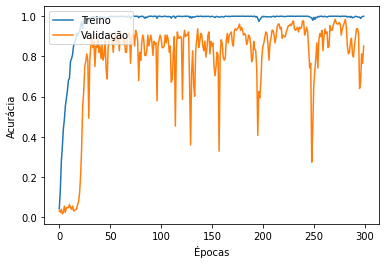

In [ ]:
with tf.device('/device:GPU:0'): 
  #hiperparametros
  BATCH_SIZE = 32
  IMG_SIZE = (299,299)
  NUM_CLASSES = 24
  INPUT_SHAPE = (299,299,3)

  # paths
  for i in range(1,6):
    path = "/content/drive/MyDrive/TCC/partition/partition-" + str(i) + os.sep
    train_dir = path + "train/"
    validation_dir =  path + "val/"
    test_dir = path + "test/" 
  ## GENERATORS
    train_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle = False
      )
    
  ## Checa se já tem pasta para os logs do modelo, senão cria
    modelo = 'shuffleNet1'
    logs_path = '/content/drive/MyDrive/TCC/checkpoint/' + modelo + os. sep + 'partition-' +str(i) + os.sep
    if not os.path.isdir(logs_path):
        !os.mkdir(logs_path)

  ## Callbacks
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=100, verbose=2,restore_best_weights=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= logs_path + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    mode='max',
    save_weights_only = False,
    save_best_only=True)
    logger = tf.keras.callbacks.CSVLogger(logs_path + 'log.out')


    EPOCHS = 300
    OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=1e-4)
    CALLBACKS = [earlystopping_callback,model_checkpoint_callback,logger]
    STEPS_PER_EPOCH = np.floor(980/BATCH_SIZE) 
    VALIDATION_STEPS = np.floor(140/BATCH_SIZE)

    model_s = Shuffle_Net(NUM_CLASSES, start_channels,input_shape)


    model_s.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,metrics=["accuracy"])


  # Treino

    history = model_s.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS, validation_data = validation_generator, 
                                validation_steps = VALIDATION_STEPS, callbacks = CALLBACKS, verbose=1)

  ## Saidas

  ## plotar gráfico da loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Perda')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "loss.jpg")
    plt.close()
    
    ## plotar gráfico da acc
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(['Treino', 'Validação'], loc='upper left')
    plt.savefig(logs_path + "acc.jpg")
    
    ## Weighted Accuracy  model_s
    y_pred = model_s.predict(test_generator,verbose=1,steps=len(test_generator))
    y_pred = np.argmax(y_pred,axis=1)
    y_true = test_generator.labels
    accuracy = sklearn.metrics.balanced_accuracy_score(y_true,y_pred)
    print("Acurácia",accuracy)
    
    ## Weighted F-Score
    f_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')
    print("F-Score",f_score)
    
    ## Precision
    precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'macro')
    print("Precisão",precision)
    
    ## Recall
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='micro')
    print("Revocação",recall)

    #matriz de cinfusão
    confusion_matriz = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print("matriz de confusão",confusion_matriz)


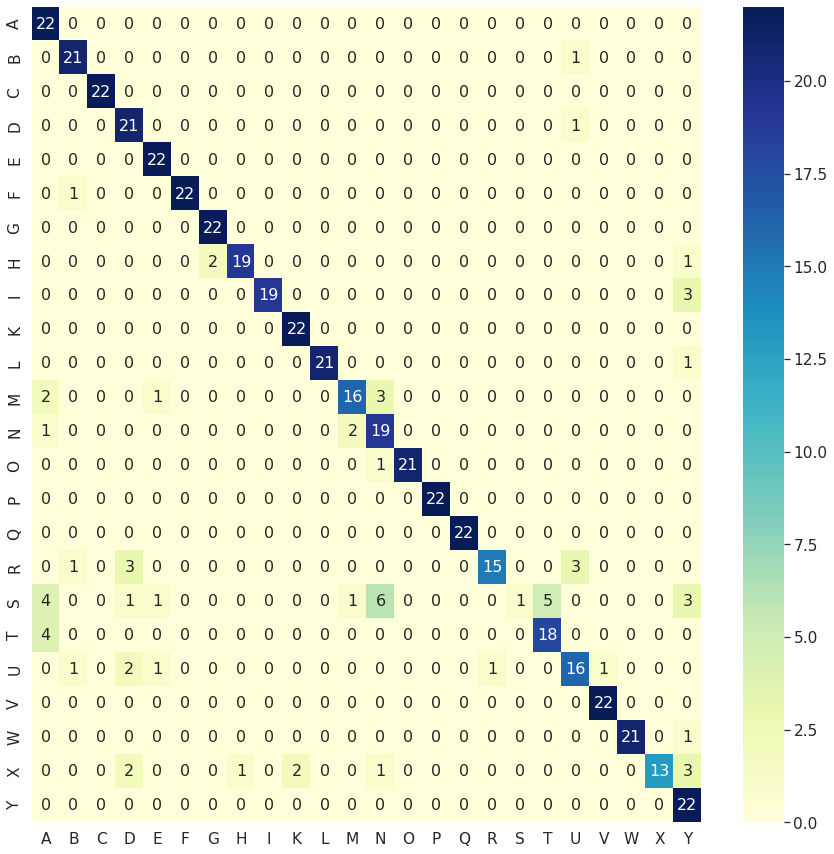

In [ ]:
classes = list(train_generator.class_indices.keys())

df_cm = pd.DataFrame(confusion_matriz, range(24), range(24))
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
plt.show()

In [ ]:
import numpy as np
confusion_matrix =  np.array([[21, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 20, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 19, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 17, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 18, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 1, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 20, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 21, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 22]])

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (299,299)
NUM_CLASSES = 24
INPUT_SHAPE = (299,299,3)
#path = "/content/drive/MyDrive/TCC/partition/partition-1" + os.sep
train_dir = "/content/drive/MyDrive/TCC/partition/partition-1/train/"
    #validation_dir =  path + "val/"
    #test_dir = path + "test/" 
  ## GENERATORS
train_datagen = ImageDataGenerator(rescale=1./255)
#    validation_datagen = ImageDataGenerator(rescale=1./255)
 #   test_datagen = ImageDataGenerator(rescale=1./255)
    
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1841 images belonging to 24 classes.


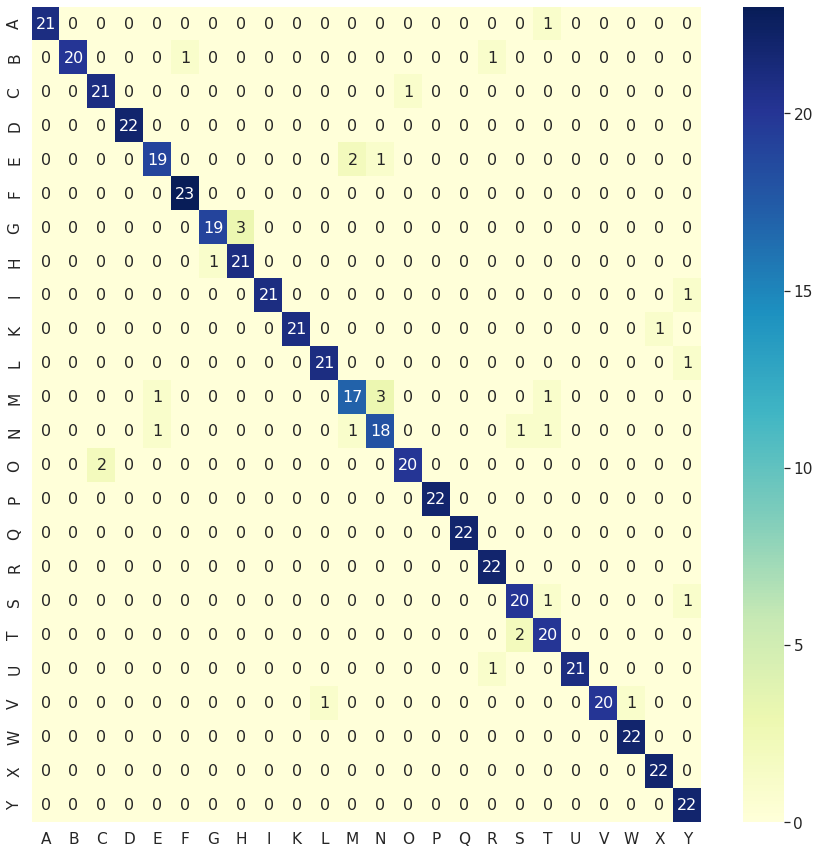

In [ ]:
classes = list(train_generator.class_indices.keys())

df_cm = pd.DataFrame(confusion_matrix, range(24), range(24))
plt.figure(figsize=(15,15))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", xticklabels= classes, yticklabels= classes) # font size
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                100*np.max(predictions_array),
                                classes[true_label]),
                                color=color)

In [ ]:
def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels


In [ ]:
predictions_labels_plot = get_labels_for_plot(y_pred)

In [ ]:
predictions_labels_plot

['A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'B',
 'U',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'D',
 'U',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'D',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'E',
 'B',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'F',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'H',
 'Y',
 'H',
 'H',
 'G',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H'

In [ ]:
y_true

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10

In [ ]:
y_pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3, 19,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  1,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7, 23,  7,  7,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8, 23,  8,  8,  8,  8, 23, 23,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10

In [ ]:
#pegar test genetrator da partition 5

In [ ]:
import matplotlib.image as mpimg

In [ ]:
y_true

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10

In [ ]:
labels_dict = test_generator.class_indices
